In [5]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

В наличии csv файл размером около 26Гб, при чтении в датафрейм будут проблемы с памятью. 
Никакого стандарта для файлов такого формата не существует. Но сначала хотя бы посмотрим на данные, предварительно считав диалет csv скриптом detect_csv_dialect.py 

In [6]:
main_path = 'D://VKR/VKR_Project/'  # путь до папки с обрабатываемым файлом(в данном случае файл помещен в папку проекта)
orig_csv_name = 'fz.csv'  # имя самого файла

In [7]:
with open(main_path+orig_csv_name, 'r', encoding='utf-8', newline='') as infile:
    dialect = csv.Sniffer().sniff(infile.read(1024))
print(
    "detected delimiter = %s\n"
    "detected doublequote = %s\n"
    "detected escapechar = %s\n"
    "detected lineterminator = %s\n"
    "detected quotechar = %s\n"
    "detected quoting = %s\n"
    "detected skipinitialspace = %s\n" %(
        dialect.delimiter, dialect.doublequote, dialect.escapechar, repr(dialect.lineterminator), dialect.quotechar, dialect.quoting, 
        dialect.skipinitialspace))

detected delimiter = ,
detected doublequote = True
detected escapechar = None
detected lineterminator = '\r\n'
detected quotechar = "
detected quoting = 0
detected skipinitialspace = False



Похоже на диалект excel, который используется по умолчанию

Parameter	Excel
- delimiter	','
- doublequote	True
- escapechar	None
- lineterminator	\r\n
- quotechar	"
- quoting	csv.QUOTE_MINIMAL
- skipinitialspace	False
- strict	False

Исходим из того, что файл все-таки соответствует некоторым общепринятым практикам, указанным в RFC 4180 Definition of the CSV Format.
Попробуем считать файл самым простым способом

In [8]:
df = pd.read_csv(main_path+orig_csv_name)

ParserError: Error tokenizing data. C error: Expected 27 fields in line 201, saw 28


Считываем первые 10 строк

In [9]:
df = pd.read_csv(main_path+orig_csv_name, nrows=10, encoding='UTF-8')
df

,1,1010101008321000006,211010101008301010100100100246820244,7707049388,"КРАСНОДАРСКИЙ ФИЛИАЛ ПАО \РОСТЕЛЕКОМ\""""",<НЕ ОПРЕДЕЛЕНО>,0101010083,"МО МВД РОССИИ \КОШЕХАБЛЬСКИЙ\""""",Республика Адыгея (Адыгея),18803020840390049244,...,2022-04-18,\N,<НЕ ОПРЕДЕЛЕНО>.2,\N.1,173380.50,0.00,"Изменение условий контракта, заключенного с единственным поставщиком (подрядчиком, исполнителем) в соответствии с пунктами 1, 8, 22, 29, 32, 34, 51 части 1 статьи 93 Федерального закона",<НЕ ОПРЕДЕЛЕНО>.3,Услуги по операциям с недвижимым имуществом,68.2
0,2,1010101008321000006,211010101008301010100100100246820244,7707049388,"ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО \РОСТЕЛЕКОМ\""""",78,101010083,"МО МВД РОССИИ \КОШЕХАБЛЬСКИЙ\""""",Республика Адыгея (Адыгея),18803020840390049244,...,2022-04-18,\N,<НЕ ОПРЕДЕЛЕНО>,\N,173380.50,0.00,"Изменение условий контракта, заключенного с ед...",<НЕ ОПРЕДЕЛЕНО>,Услуги по операциям с недвижимым имуществом,68.2
1,3,1010101008321000007,211010101008301010100100100236820244,105076166,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \МАН ...,1,101010083,"МО МВД РОССИИ \КОШЕХАБЛЬСКИЙ\""""",Республика Адыгея (Адыгея),18803020840390049244,...,2022-04-19,\N,<НЕ ОПРЕДЕЛЕНО>,\N,221778.00,\N,<НЕ ОПРЕДЕЛЕНО>,<НЕ ОПРЕДЕЛЕНО>,Услуги по операциям с недвижимым имуществом,68.2
2,4,1010501691421000144,211010501691401050100101960012640323,6630008994,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \КРУС...,66,105016914,ГУ-РО ФОНДА СОЦИАЛЬНОГО СТРАХОВАНИЯ РОССИЙСКОЙ...,Республика Адыгея (Адыгея),39310030440139570323,...,2022-09-27,\N,<НЕ ОПРЕДЕЛЕНО>,281119.60,281119.60,0.00,<НЕ ОПРЕДЕЛЕНО>,<НЕ ОПРЕДЕЛЕНО>,"Оборудование компьютерное, электронное и оптич...",26.4
3,6,1010501691421000148,211010501691401050100101940012640323,7743763319,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \МЕДИ...,77,105016914,ГУ-РО ФОНДА СОЦИАЛЬНОГО СТРАХОВАНИЯ РОССИЙСКОЙ...,Республика Адыгея (Адыгея),39310030440139570323,...,\N,\N,<НЕ ОПРЕДЕЛЕНО>,120597.44,77785.15,0.00,<НЕ ОПРЕДЕЛЕНО>,<НЕ ОПРЕДЕЛЕНО>,"Оборудование компьютерное, электронное и оптич...",26.4
4,8,1010501691421000150,211010501691401050100102290015310244,7724490000,"АКЦИОНЕРНОЕ ОБЩЕСТВО \ПОЧТА РОССИИ\""""",77,105016914,ГУ-РО ФОНДА СОЦИАЛЬНОГО СТРАХОВАНИЯ РОССИЙСКОЙ...,Республика Адыгея (Адыгея),39310060370290059244,...,2021-12-13,\N,<НЕ ОПРЕДЕЛЕНО>,\N,50000.00,\N,<НЕ ОПРЕДЕЛЕНО>,<НЕ ОПРЕДЕЛЕНО>,Услуги почтовой связи и услуги курьерские,53.1
5,9,1010501691421000151,211010501691401050100102010012660323,7130033105,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \СЕРВ...,71,105016914,ГУ-РО ФОНДА СОЦИАЛЬНОГО СТРАХОВАНИЯ РОССИЙСКОЙ...,Республика Адыгея (Адыгея),39310030440139570323,...,\N,\N,<НЕ ОПРЕДЕЛЕНО>,2190836.70,2190836.70,0.00,<НЕ ОПРЕДЕЛЕНО>,<НЕ ОПРЕДЕЛЕНО>,"Оборудование компьютерное, электронное и оптич...",26.6
6,10,1010501691421000152,211010501691401050100101930012660323,7105057864,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \МЕДП...,71,105016914,ГУ-РО ФОНДА СОЦИАЛЬНОГО СТРАХОВАНИЯ РОССИЙСКОЙ...,Республика Адыгея (Адыгея),39310030440139570323,...,2022-07-20,\N,<НЕ ОПРЕДЕЛЕНО>,111478.00,111478.00,0.00,<НЕ ОПРЕДЕЛЕНО>,<НЕ ОПРЕДЕЛЕНО>,"Оборудование компьютерное, электронное и оптич...",26.6
7,11,1010501691421000153,211010501691401050100102040013250323,2310170944,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \РАДУ...,23,105016914,ГУ-РО ФОНДА СОЦИАЛЬНОГО СТРАХОВАНИЯ РОССИЙСКОЙ...,Республика Адыгея (Адыгея),39310030440139570323,...,\N,\N,<НЕ ОПРЕДЕЛЕНО>,255234.00,255234.00,0.00,<НЕ ОПРЕДЕЛЕНО>,<НЕ ОПРЕДЕЛЕНО>,Изделия готовые прочие,32.5
8,12,1010501691421000154,211010501691401050100102040053250323,2310170944,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \РАДУ...,23,105016914,ГУ-РО ФОНДА СОЦИАЛЬНОГО СТРАХОВАНИЯ РОССИЙСКОЙ...,Республика Адыгея (Адыгея),39310030440139570323,...,\N,\N,<НЕ ОПРЕДЕЛЕНО>,998760.00,998760.00,0.00,<НЕ ОПРЕДЕЛЕНО>,<НЕ ОПРЕДЕЛЕНО>,Изделия готовые прочие,32.5
9,13,1010501691421000155,211010501691401050100101950013250323,3328495991,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \ИННО...,33,105016914,ГУ-РО ФОНДА СОЦИАЛЬНОГО СТРАХОВАНИЯ РО

Обнаруживаем, что в файле отсутствует заголовок, и первая строка принимается за него. Уточнили, что большинство записей содержит 27 столбцов. Пока при загрузке в датафрейм будем использовать параметр header = None.

Одним из решений пробемы токенизации является пропуск строк с ошибками. При таком количестве объектов для проведения анализа это возможно. Но оставим этот вариант на крайний случай.

Попробуем в явном виде считать 28 колонок, чтобы посмотреть что не так с 201 строкой. Для этого определяем список из индексов и используем его в параметре use_cols, чтобы в явном виде считать ошибочную строку, используем параметр skiprows и nrows для чтения ограниченного количества строк

In [10]:
usecols_28=list(range(0,27))

In [11]:
df = pd.read_csv(main_path+orig_csv_name, usecols=usecols_28, skiprows=199, nrows=2, encoding='UTF-8', header=None)
df.T

,0,1
0,259,260
1,1022200249621000006,1022200249621000007
2,211022200249602220100100140363511247,211022200249602220100100132433530247
3,275038496,222007342
4,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \ЭНЕР...,МУНИЦИПАЛЬНОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ СЕЛЬСКОГО ...
5,02,"СТРОИТЕЛЬНАЯ КАМПАНИЯ\"""""
6,222002496,2
7,ОТДЕЛ МВД РОССИИ ПО ЗИАНЧУРИНСКОМУ РАЙОНУ,0222002496
8,Республика Башкортостан,ОТДЕЛ МВД РОССИИ ПО ЗИАНЧУРИНСКОМУ РАЙОНУ
9,18803020840392501247,Республика Башкортостан


Видим, что строка в 5 столбце разделилась. Выведем отдельно строку с ошибкой

In [12]:
df_bad = pd.read_csv(main_path+orig_csv_name, usecols=usecols_28, skiprows=200, nrows=1, encoding='UTF-8', header=None)
df_bad.values.tolist()

[[260,
  1022200249621000007,
  '211022200249602220100100132433530247',
  222007342,
  'МУНИЦИПАЛЬНОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ СЕЛЬСКОГО ПОСЕЛЕНИЯ ИСЯНГУЛОВСКИЙ СЕЛЬСОВЕТ МУНИЦИПАЛЬНОГО РАЙОНА ЗИАНЧУРИНСКИЙ РАЙОН РЕСПУБЛИКИ БАШКОРТОСТАН \\ЖИЛИЩНО-КОММУНАЛЬНАЯ',
  'СТРОИТЕЛЬНАЯ КАМПАНИЯ\\""',
  2,
  222002496,
  'ОТДЕЛ МВД РОССИИ ПО ЗИАНЧУРИНСКОМУ РАЙОНУ',
  'Республика Башкортостан',
  '18803020840392501247',
  'Контракт исполнен',
  '<НЕ ОПРЕДЕЛЕНО>',
  'федеральный бюджет',
  '2021-12-13',
  '2021-12-13',
  '2021-12-31',
  '2022-01-14',
  '2021-12-29',
  '\\N',
  '<НЕ ОПРЕДЕЛЕНО>',
  '\\N',
  286495.03,
  '\\N',
  '<НЕ ОПРЕДЕЛЕНО>',
  '<НЕ ОПРЕДЕЛЕНО>',
  'Электроэнергия, газ, пар и кондиционирование воздуха']]

Проверяем запись по номеру контракта в реестре контрактов на сайте https://zakupki.gov.ru. В карточке контракта указан поставщик МУНИЦИПАЛЬНОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ СЕЛЬСКОГО ПОСЕЛЕНИЯ ИСЯНГУЛОВСКИЙ СЕЛЬСОВЕТ МУНИЦИПАЛЬНОГО РАЙОНА ЗИАНЧУРИНСКИЙ РАЙОН РЕСПУБЛИКИ БАШКОРТОСТАН "ЖИЛИЩНО-КОММУНАЛЬНАЯ,СТРОИТЕЛЬНАЯ КАМПАНИЯ". То есть в строке имеется наименование в двойных кавычках, которое содержит в себе ','. Внутри кавычек также видим символ '\'. Подозреваем проблемы с экранированием символов, которые приводят к неправильному парсингу. Добавим в функцию чтения параметр escapechar = '\\'

In [13]:
df = pd.read_csv(main_path+orig_csv_name, nrows=201, encoding='UTF-8', header=None, escapechar='\\')

In [14]:
#перепроверяем следующий кусок данных на большем количестве строк
df= pd.read_csv(main_path+orig_csv_name, skiprows=201, nrows=10000, encoding='UTF-8', header=None)
df

ParserError: Error tokenizing data. C error: Expected 27 fields in line 363, saw 29


In [15]:
df_bad = pd.read_csv(main_path+orig_csv_name, skiprows=362, nrows=1, encoding='UTF-8', header=None)
df_bad.T

,0
0,438
1,1027401123721000115
2,211027401123702740100100130095811244
3,7729350422
4,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \ИЗДА...
5,77
6,274011237
7,ФГБОУ ВО \БАШКИРСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТ...
8,БАШКИРСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ
9,"БАШГУ"""


In [16]:
# и снова проблемы со строками с наименованиями организаций, которые опять решаются добавлением escapechar
df_bad = pd.read_csv(main_path+orig_csv_name, skiprows = 362, nrows = 1, encoding = 'UTF-8', header=None, escapechar = '\\')
df_bad.T

,0
0,438
1,1027401123721000115
2,211027401123702740100100130095811244
3,7729350422
4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ИЗДА..."
5,77
6,274011237
7,"ФГБОУ ВО ""БАШКИРСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТ..."
8,Республика Башкортостан
9,<НЕ ОПРЕДЕЛЕНО>


Указанные ниже скрипты работают долго. Их коды не приведены, приложены отдельными файлами

С помощью скрипта raw_file_count_rows.py считаем весь файл целиком и посчитаем кол-во строк без escapechar:

TOTAL number of rows in the CSV file: 29320202
Number of GOOD rows in the CSV file: 28538110
Number of BAD rows in the CSV file: 782092
Percentage of BAD rows in the CSV file: 2.66741682066174

Сохранили "плохие" строки в отдельный файл bad_rows.csv. При просмотре файла кажется, что ошибка при чтении всего одна и только с наименованиями.

После подсчета строк с параметром escapechar = '\\' получили:

TOTAL number of rows in the CSV file: 29320202
Number of BAD rows in the CSV file: 0
Number of GOOD rows in the CSV file: 29320202
Percentage of BAD rows in the CSV file: 0.0

Cчитаем проблему чтения решенной.

Теперь анализируем данные в файле. Уже известно, что у нас в наличии таблица на 29320202 строк и 27 столбцов без заголовка.
Можно запросить у заказчика расшифровку столбцов, чтобы понимать смысл и тип данных. Это может пригодиться для создания заголовков и последующих манипуляций с данными. Задание типа данных также может ускорить чтение, контролировать качество данных.

Проверив несколько контрактов в реестре контрактов на сайте https://zakupki.gov.ru, удалось установить названия практически всех столбцов
1. - идентификатор записи, число
2. - реестровый номер контракта, число
3. - идентификационный код закупки, число
4. - ИНН поставщика, число
5. - поставщик(наименование юридического лица или ФИО физического лица), строка
6. - неизвестно, число
7. - ИНН заказчика, число
8. - наименование заказчика, строка
9. - регион заказчика(поставки), строка
10. - код бюджетной классификации, число
11. - статус контракта, строка
12. - предмет контракта(объект закупки), строка
13. - источник финансирования, строка
14. - дата заключения контракта, дата
15. - дата начала исполнения, дата
16. - дата окончания исполнения контракта(срок исполнения), дата
17. - дата
18. - дата
19. - дата
20. - основание расторжения контракта, строка //предположительно связано со статусом контракта "исполнение прекращено"
21. - начальная(максимальная) цена контракта, число
22. - цена контракта в рублях, число
23. - изменения в цене контракта, число //предположительно связанно с изменениями условий контракта
24. - обоснование внесений изменений в контракт, строка
25. - обозначение раздела в ОКПД2, символ из спиcка заглавных латинских букв [A-U]. Тут же появляется новое значение для пропуска '<НЕ РАСПРЕДЕЛЕНО>'
26. - объект закупки по коду ОКПД2, строка
27. - код ОКПД2, строка

Большинство признаков - категориальные данные, которые будут считываться в скриптах как строки. Для визуализации подойдут столбчатые диаграммы. Для использования в анализе их необходимо будет закодировать.

Количественные данные на данный момент есть только в колонках, связанными со стоимостью контракта.

Возвращаемся к ТЗ.

Задача: необходимо на основе данных с ftp.zakupki.gov.ru научиться определять группу, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.

Группы могут быть следующими:

- Строительно-монтажные работы (СМР)
- Проектно-изыскательские работы (ПИР)
- Строительный надзор
- Подключение коммуникаций
- Прочее.

По ОКПД-2 контракты в общем случае должны разделяться так:
- Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
- Проектно-изыскательские работы (ПИР) - 41.1, 71.1
- Подключение коммуникаций - 43.22
- Строительный надзор – четкой группы нет.

По указанным в ТЗ группам набор данных не размечен, при этом ОКПД2 может быть изначально выбран неправильно. Разметку может провести сам заказчик или отдать это задание сторонней компании. У нас такой возможности нет. Будем считать, что коды ОКПД2 проставлены верно, и мы можем отобрать по этому признаку только нужные для анализа строки, сократив объем данных. Попробуем для начала принять за метки класса коды ОКПД2.

Для отбора используем скрипт select_by_OKPD2.py. Отобранные строки записаны в файл selected_rows.csv с разделителем '|'.
Снизили размер файла до 2ГБ. Отбор признаков, удаление дублей и пропусков будем проводить уже с использованием библиотеки pandas.

In [17]:
# определим имя нового файла и переменные для чтения в датафрейм
new_csv_name = 'selected_rows.csv'
escapechar='\\'
new_del='|'
col_names = ['infile_entry_id',
             'contract_number',
             'purchase_id',
             'supplier_INN',
             'supplier_name',
             'x1',
             'customer_INN',
             'customer_name',
             'customer_region',
             'purchase_KBK',
             'contract_status',
             'contract_subject',
             'contract_budget_type',
             'contract_start_date',
             'contract_exec_date',
             'contract_end_date',
             'date1',
             'date2',
             'date3',
             'contract_termination_reason',
             'contract_max_price',
             'contract_act_price',
             'contract_change_price',
             'contract_change_reason',
             'OKPD2_section',
             'OKPD2_code_description',
             'OKPD2_code']

#словарь для задания dtype при чтении данных в dataframe
col_dtypes = {'infile_entry_id': int,
              'contract_number' : str,
              'purchase_id' : str,
              'supplier_INN' : str,
              'supplier_name' : str,
              'x1' : str,
              'customer_INN' : str,
              'customer_name': str,
              'customer_region': str,
              'purchase_KBK': str,
              'contract_status': str,
              'contract_subject': str,
              'contract_budget_type': str,
              'contract_start_date': str,
              'contract_exec_date': str,
              'contract_end_date': str,
              'date1': str,
              'date2': str,
              'date3' : str,
              'contract_termination_reason': str,
              'contract_max_price' : float,
              'contract_act_price' : float,
              'contract_change_price' : float,
              'contract_change_reason' : str,
              'OKPD2_section': str,
              'OKPD2_code_description' : str,
              'OKPD2_code' : str }
# долполнительные значения для пропусков
extra_na=['N', '<НЕ ОПРЕДЕЛЕНО>', '<НЕ РАСПРЕДЕЛЕНО>', 0]

In [18]:
df = pd.read_csv(main_path+new_csv_name, encoding='UTF-8', escapechar=escapechar, delimiter=new_del,
                 names= col_names, dtype=col_dtypes, na_values=extra_na)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002332 entries, 0 to 2002331
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   infile_entry_id              int32  
 1   contract_number              object 
 2   purchase_id                  object 
 3   supplier_INN                 object 
 4   supplier_name                object 
 5   x1                           object 
 6   customer_INN                 object 
 7   customer_name                object 
 8   customer_region              object 
 9   purchase_KBK                 object 
 10  contract_status              object 
 11  contract_subject             object 
 12  contract_budget_type         object 
 13  contract_start_date          object 
 14  contract_exec_date           object 
 15  contract_end_date            object 
 16  date1                        object 
 17  date2                        object 
 18  date3                        object 
 19  

Размер датафрейма соответствует ожиданиям. Посчитаем пропущенные значения

In [19]:
# сохраним датафрейм в текущем состоянии
df.to_pickle("selected_by_OKPD2_full.pkl")

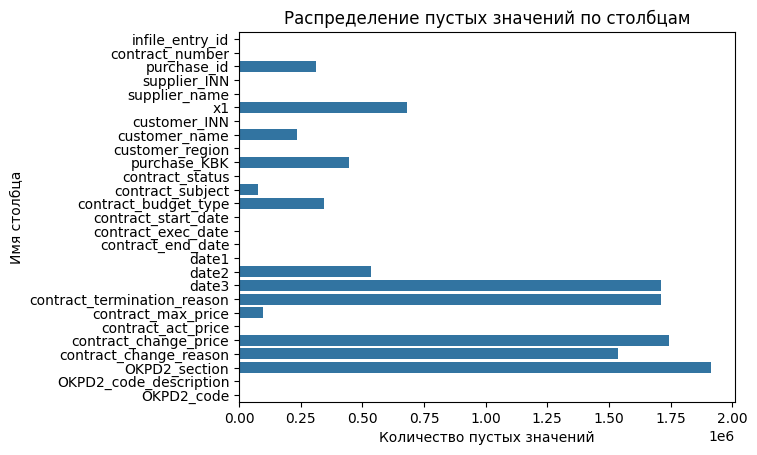

In [20]:
#посмотрим на количество нулевых значений
null_data = df.isnull().sum()
null_data_plot = sns.barplot(y = null_data.index, x = null_data.values)

plt.title('Распределение пустых значений по столбцам')
plt.xlabel('Количество пустых значений')
plt.ylabel('Имя столбца');

В идеале конечно нужно дозаполнить все строки по имеющейся на сайте госзакупок информации. Но пока попробуем просто отобрать признаки.
Номер закупки оставляем для поиска дублей. Основные признаки для анализа - объект закупки, дополнительные по ТЗ - стоимость(фактическая цена) и длительность в днях(разница между датами начала и окончания контракта) и на всякий случай оставим ИНН поставщика. Код ОКПД2 - таргет для задач классификации. Максимум пропусков как раз находится в оставшихся признаках.

In [21]:
df.drop(columns=['infile_entry_id', 'purchase_id', 'supplier_name', 'x1', 'customer_INN', 'customer_name', 'customer_region', 'purchase_KBK', 
       'contract_status', 'contract_budget_type', 'contract_exec_date', 'date1', 'date2', 'date3', 'contract_termination_reason', 'contract_max_price', 
       'contract_change_price', 'contract_change_reason', 'OKPD2_section'], axis=1, inplace = True)
df.shape

(2002332, 8)

In [22]:
# удалим объекты с хотя бы одним пустым значением
df.dropna(axis=0, how='any', inplace=True)
df.shape

(1925899, 8)

In [23]:
# убедимся, что все сработало
df.isnull().sum()

contract_number           0
supplier_INN              0
contract_subject          0
contract_start_date       0
contract_end_date         0
contract_act_price        0
OKPD2_code_description    0
OKPD2_code                0
dtype: int64

In [24]:
df.shape
#размерность после удаления пропусков

(1925899, 8)

In [25]:
# преобразуем даты
df['contract_start_date']=pd.to_datetime(df['contract_start_date'], format='%Y-%m-%d')

In [26]:
df['contract_end_date']=pd.to_datetime(df['contract_end_date'], format='%Y-%m-%d')

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 8022-04-29, at position 3607. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [27]:
# заменим ошибочные значения на пустые и запишем их в файл
df['contract_end_date']=pd.to_datetime(df['contract_end_date'], format='%Y-%m-%d', errors = 'coerce')
df_time_error = df.loc[df['contract_end_date'].isnull()]
df_time_error.to_csv('contract_end_date_error.csv')

In [28]:
# а в csv даты отображаются корректно
df_time_error.T

,1824193,1824194,1860548
contract_number,3451003254322000031,3451003254322000031,2540619804722000250
supplier_INN,4501194763,4501194763,540430991916
contract_subject,Ремонт дорожного покрытия автомобильных дорог ...,Ремонт дорожного покрытия автомобильных дорог ...,Выполнение работ по подготовке системы отоплен...
contract_start_date,2022-08-12 00:00:00,2022-08-12 00:00:00,2022-06-20 00:00:00
contract_end_date,NaT,NaT,NaT
contract_act_price,10520343.1,10520343.1,28712.32
OKPD2_code_description,42.1,42.1,43.2
OKPD2_code,42.1,42.1,43.2


In [29]:
#не ясно почему так, решено не страдать за три строки
df.dropna(axis=0, how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1925896 entries, 0 to 2002331
Data columns (total 8 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   contract_number         object        
 1   supplier_INN            object        
 2   contract_subject        object        
 3   contract_start_date     datetime64[ns]
 4   contract_end_date       datetime64[ns]
 5   contract_act_price      float64       
 6   OKPD2_code_description  object        
 7   OKPD2_code              object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 132.2+ MB


С датами закончили. Перходим к работе с дублями.
Реестровый номер закупки однозначно идентифицирует ее и будет использоваться в качестве основного значения для определения дублей.

Еще в начале мы видели дублирование номеров контрактов. Можно заранее уточнить логику формирования файла, и сформулировать правила определения задублированных строк. Но делать это имеет смысл после заполнения пропусков и перед отбором признаков.
Даже при заполненных пропусках у нас нет возможности уточнить какие строка считать дублями. Поэтому мы заранее отобрали признаки и сначала будем удалять полностью совпадающие строки.

В ТЗ указано, что один контракт может относиться сразу к нескольким группам ОКПД2. Например, контракт 1020200039521000238. 
Такие контракты имеют несколько кодов ОКПД2 и внесены в файл отдельными строками с единым номером контракта. При просмотре несольких таких контрактов замечено, что у них общее описание, общая цена контракта и даты, хотя и было высказано предположение. Можно поробовать добавить в такие объекты закупки описания кодов ОКПД2, загрузить дополнительно цену по категориям. Пока сохраним их в отдельный файл.

Другой проблемой может являться обобщенное описание предмета закупки. Запишем такие объекты и отдельно проверить как на них работает модель.

In [30]:
# убираем полностью совпадающие строки
df.drop_duplicates()
df.shape

(1925896, 8)

In [31]:
# получается, что уже все строки уникальны. Проверим что дубли контрактов еще остались
df.duplicated(subset=['contract_number']).sum()

252273

In [32]:
# проверим, что номера дубли у номеров контрактов имеются одинаковые даты
df.duplicated(subset=['contract_number', 'contract_start_date','contract_end_date']).sum()

252273

то есть дальше уже фильтруем только по номерам контрактов. Перед этим сначала вычислим длительность контрактов в днях
Сначала добавим колонку для этих значений

In [33]:
df.insert (loc= 5 , column='contract_duration_days', value=None)

In [34]:
df['contract_duration_days'] = (df['contract_end_date'] - df['contract_start_date']).dt.days

In [35]:
# сохраним текущее состояние датафрейма
df.drop(columns=['contract_start_date', 'contract_end_date'], axis=0, inplace=True)
df.to_pickle('with_same_contract_diff_OKPD2.pkl')

In [36]:
df.shape

(1925896, 7)

In [37]:
df.head()

,contract_number,supplier_INN,contract_subject,contract_duration_days,contract_act_price,OKPD2_code_description,OKPD2_code
0,1026802173421000064,743201168885,прочая закупка услуг (услуги по монтажу и пуск...,21,248515.44,Работы строительные специализированные,43.2
1,1027401123721000132,0268065918,выполнение работ по текущему ремонту заполнени...,19,271471.50,Работы строительные специализированные,43.3
2,1027401123721000133,0272907606,выполнение работ по текущему ремонту заполнени...,16,154464.51,Работы строительные специализированные,43.3
3,1027401123721000134,0272907606,выполнение работ по текущему ремонту заполнени...,16,405455.16,Работы строительные специализированные,43.3
4,1027401123721000135,0268065918,выполнение работ по текущему ремонту заполнени...,19,87812.76,Работы строительные специализированные,43.3


In [38]:
# пока все идет по плану. Посчитаем кол-во вхождений каждого контракта
contract_number_count = df['contract_number'].value_counts()
contract_number_count

contract_number
3434530185621000050    238
2720300186018000133     60
2720300186018000259     56
2720300186017000201     54
2720300186019000300     52
                      ... 
3132212081921000009      1
3132211895421000005      1
3132111792621000001      1
3132111429821000026      1
2782534239021000055      1
Name: count, Length: 1673623, dtype: int64

In [39]:
# Перепроверим записи с этими индексами с записями из датафрейма, который мы получили после первичной обработки исходного файла скриптами
df_test=pd.read_pickle('selected_by_OKPD2_full.pkl')
df_test.shape

(2002332, 27)

In [40]:
df_test[df_test['contract_number']=='3434530185621000050'].to_csv('test.csv')
#видим различия только в KБК. Исходим из того, что и во всех остальных строках также

In [41]:
df_test[df_test['contract_number']=='2782534239021000055']

,infile_entry_id,contract_number,purchase_id,supplier_INN,supplier_name,x1,customer_INN,customer_name,customer_region,purchase_KBK,...,date2,date3,contract_termination_reason,contract_max_price,contract_act_price,contract_change_price,contract_change_reason,OKPD2_section,OKPD2_code_description,OKPD2_code
2002331,35096565,2782534239021000055,212782534239078020100101320017112414,7839418049,"ООО ""ГЕО-ПРОЕКТ""",NaN,7825342390,"СПБ ГКУ ""ДИРЕКЦИЯ ТРАНСПОРТНОГО СТРОИТЕЛЬСТВА""",Город Санкт-Петербург город федерального значения,86804091630099250414,...,NaN,NaN,NaN,19847970.77,16477449.29,-2372550.71,NaN,NaN,71.1,71.1


эта запись действительно уникальна. Осталось только выделить из датафрейма записи с одинаковым номером контракта, но разным кодом ОКПД2

In [42]:
# индексы с единичным вхождением в contract_number_count считаем уникальными(unique_rows_indexes)
unique_rows_indexes = contract_number_count[contract_number_count.values==1].index
# остальные запишем как индексы дубликатов(dup_rows_indexes)
dup_rows_indexes = contract_number_count[contract_number_count.values!=1].index

In [43]:
# теперь запишем в отдельный датафрейм строки с индексами из dup_rows_indexes
dup_rows_df = df[df['contract_number'].isin(dup_rows_indexes)]
dup_rows_df.to_pickle('anomaly_dups.pkl')
dup_rows_df.head()

,contract_number,supplier_INN,contract_subject,contract_duration_days,contract_act_price,OKPD2_code_description,OKPD2_code
73,1151592056121000010,1513077508,Проведение работ по текущему ремонту помещений,97,472100.00,Работы строительные специализированные,43.3
74,1151592056121000010,1513077508,Проведение работ по текущему ремонту помещений,97,472100.00,Работы строительные специализированные,43.3
113,1190106535821000051,191000306752,Обслуживание вентиляции,390,18000.00,Работы строительные специализированные,43.2
114,1190106535821000051,191000306752,Обслуживание вентиляции,390,18000.00,Работы строительные специализированные,43.2
201,1263204164721000165,7724433650,Расходы на оснащение объектов дорожного хозяйс...,108,31941296.51,Работы строительные специализированные,43.2


In [44]:
# отберем уникальные строки
df = df[df['contract_number'].isin(unique_rows_indexes)]
df.to_pickle('unique_rows.pkl')
df.head()

,contract_number,supplier_INN,contract_subject,contract_duration_days,contract_act_price,OKPD2_code_description,OKPD2_code
0,1026802173421000064,743201168885,прочая закупка услуг (услуги по монтажу и пуск...,21,248515.44,Работы строительные специализированные,43.2
1,1027401123721000132,0268065918,выполнение работ по текущему ремонту заполнени...,19,271471.50,Работы строительные специализированные,43.3
2,1027401123721000133,0272907606,выполнение работ по текущему ремонту заполнени...,16,154464.51,Работы строительные специализированные,43.3
3,1027401123721000134,0272907606,выполнение работ по текущему ремонту заполнени...,16,405455.16,Работы строительные специализированные,43.3
4,1027401123721000135,0268065918,выполнение работ по текущему ремонту заполнени...,19,87812.76,Работы строительные специализированные,43.3


In [45]:
dup_rows_df.shape

(450940, 7)

In [46]:
df.shape

(1474956, 7)

In [47]:
450940 + 1474956

1925896

In [48]:
# ничего не потеряли
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1474956 entries, 0 to 2002331
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   contract_number         1474956 non-null  object 
 1   supplier_INN            1474956 non-null  object 
 2   contract_subject        1474956 non-null  object 
 3   contract_duration_days  1474956 non-null  int64  
 4   contract_act_price      1474956 non-null  float64
 5   OKPD2_code_description  1474956 non-null  object 
 6   OKPD2_code              1474956 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 90.0+ MB


In [49]:
df.duplicated(subset=['contract_number']).sum()

0

Считаем, что с основной очисткой датасета справились. У нас остался датафрейм (1474956, 6).

Теперь посмотрим на сами данные. 
1. contract_number - уже в принципе не очень нужен, но можно оставить как идентификатор
2. supplier_INN - в дальнейшем для задач классификации нужно будет закодировать
3. contract_subject - основной для анализа признак, оставляем строкой
4. contract_duration_days - уже число
5. contract_act_price - уже число
6. OKPD2_description - будет использоваьтся в выводе рекомендательной системы, оставляем строкой
7. OKPD2_code - необходимо закодировать

Кодов ОКПД2 у нас немного, посмотрим сколько разных ИНН

In [50]:
df['supplier_INN'].value_counts()

supplier_INN
2464019742      1626
0274144861      1403
5036065113      1099
3250510627      1067
7445026711      1054
                ... 
667004802179       1
6671091127         1
6686116367         1
332701155821       1
4312143964         1
Name: count, Length: 174801, dtype: int64

Уникальных значений много. OHE не подойдет. Если дойдем до проверки теории о влиянии этого признака на категорию, нужно будет использовать какой-то другой метод, возможно, HashEncoding. Колонка с кодами OKPD2_code имеет всего 10 значений, сразу переведем их в категориальные данные

In [51]:
df['OKPD2_code'] = pd.Categorical(df.OKPD2_code)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1474956 entries, 0 to 2002331
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   contract_number         1474956 non-null  object  
 1   supplier_INN            1474956 non-null  object  
 2   contract_subject        1474956 non-null  object  
 3   contract_duration_days  1474956 non-null  int64   
 4   contract_act_price      1474956 non-null  float64 
 5   OKPD2_code_description  1474956 non-null  object  
 6   OKPD2_code              1474956 non-null  category
dtypes: category(1), float64(1), int64(1), object(4)
memory usage: 80.2+ MB


In [53]:
# посмотрим как было до дублей
df_test = pd.read_pickle('selected_by_OKPD2_full.pkl')
df_test['OKPD2_code'] = pd.Categorical(df_test.OKPD2_code)

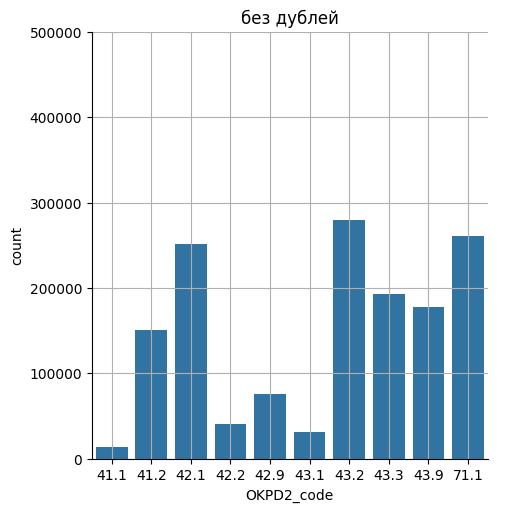

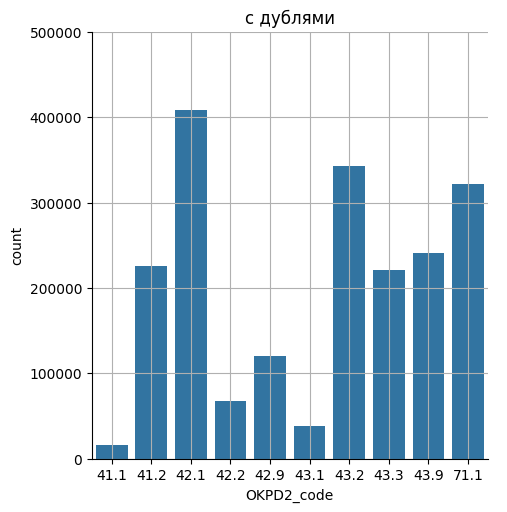

In [54]:
sns.catplot(x = 'OKPD2_code', data = df, kind = 'count')
plt.grid()
plt.ylim([0, 500000]);
plt.title('без дублей')
sns.catplot(x = 'OKPD2_code', data = df_test, kind = 'count')
plt.title('с дублями')
plt.grid()
plt.ylim([0, 500000]);

Графики похожи, выбивается только одна категория, но удаление дублей не снизило критично кол-во предметов закупки по категориям. Отмечаем изначальную несбалансированность классов.
Изучим предлагемые тексты. Предметом контрактов (объекты закупки) являются поставки товаров, выполнение работ, оказание услуг соответственно для федеральных нужд, нужд субъекта Российской Федерации, муниципальных нужд. Соответственно, в описаниях часто встречаются слова "поставка", "приобретение", "закупка", или стандартные словосочетания "выполнение работ", "оказание услуг", дополенные типом товара, указанием типа работ или услуг, также с использованием типичных для отраслей терминов. Дополнительно может указываться объект работ в виде наименования организации или адреса.
Так как на самых первых шагах предобработки записи были отсортированы, перед работой перемешаем их и сделаем копию датафрейма

In [55]:
def clean_text(sent):
    sent = re.sub(r'[-,.;:\/\(\)\[\]\n\t]', ' ', sent) #заменяем на пробелы лишние символы
    sent = re.sub(r'[^а-яёА-ЯЁ\s]', '', sent)
    #sent = re.sub(r'^[А-Я]', sent[:1].lower(), sent) # меняем регистр у первой буквы в строке
    #sent = re.sub(r'[А-Я].*$', '', sent) # удаляем  все, после встреченной заглавной буквы в надеже изюавиться от адресов и 
    sent=' '.join([w for w in sent.split() if len(w)>3])
    sent = re.sub(r'\s{2,}', ' ', sent)
    sent = sent.lower()
    return sent

In [56]:
test = 'Выполнение работ по подготовке системы отопления к зимнему отопительному сезону 2022-2023 г.г.'

In [57]:
clean_test = clean_text(test)
clean_test

'выполнение работ подготовке системы отопления зимнему отопительному сезону'

In [58]:
MIN_CHARS = 4
MAX_CHARS = 10
def tokenizer(sent, min_chars=MIN_CHARS, max_chars=MAX_CHARS, lemmatize=True):
    if lemmatize:
        stemmer = nltk.stem.SnowballStemmer("russian")
        tokens = [stemmer.stem(w) for w in word_tokenize(sent)]
    else:
        tokens = [w for w in word_tokenize(sent)]
    token = [w for w in tokens if (len(w) > min_chars and len(w) < max_chars)]
    return token 

In [59]:
tok_test = tokenizer(clean_test)
tok_test

['выполнен', 'работ', 'подготовк', 'систем', 'отоплен', 'сезон']

In [67]:
def clean_sentences(df):
    df['cleaned_subject'] = df['contract_subject'].apply(clean_text)
    df['tok_lem_sentence'] = df['cleaned_subject'].apply(lambda x: tokenizer(x, min_chars=MIN_CHARS, max_chars=MAX_CHARS))
    return df

In [74]:
df = clean_sentences(df)


KeyboardInterrupt



In [75]:
df

,contract_number,supplier_INN,contract_subject,contract_duration_days,contract_act_price,OKPD2_code_description,OKPD2_code,cleaned_subject,tok_lem_sentence
0,1026802173421000064,743201168885,прочая закупка услуг (услуги по монтажу и пуск...,21,248515.44,Работы строительные специализированные,43.2,прочая закупка услуг услуги монтажу пусконалад...,"[закупк, услуг, услуг, монтаж, вытяжн, вентиля..."
1,1027401123721000132,0268065918,выполнение работ по текущему ремонту заполнени...,19,271471.50,Работы строительные специализированные,43.3,выполнение работ текущему ремонту заполнений о...,"[выполнен, работ, текущ, ремонт, заполнен, про..."
2,1027401123721000133,0272907606,выполнение работ по текущему ремонту заполнени...,16,154464.51,Работы строительные специализированные,43.3,выполнение работ текущему ремонту заполнений о...,"[выполнен, работ, текущ, ремонт, заполнен, про..."
3,1027401123721000134,0272907606,выполнение работ по текущему ремонту заполнени...,16,405455.16,Работы строительные специализированные,43.3,выполнение работ текущему ремонту заполнений о...,"[выполнен, работ, текущ, ремонт, заполнен, про..."
4,1027401123721000135,0268065918,выполнение работ по текущему ремонту заполнени...,19,87812.76,Работы строительные специализированные,43.3,выполнение работ текущему ремонту заполнений о...,"[выполнен, работ, текущ, ремонт, заполнен, про..."
...,...,...,...,...,...,...,...,...,...
2002324,2561007002222000014,5610080648,Выполнение работ по капитальному ремонту автом...,291,63797556.18,42.1,42.1,выполнение работ капитальному ремонту автомоби...,"[выполнен, работ, капитальн, ремонт, дорог, ор..."
2002325,3591401673222000086,5914016796,Выполнение работ по текущему ремонту крыльца з...,82,65017.62,43.9,43.9,выполнение работ текущему ремонту крыльца здан...,"[выполнен, работ, текущ, ремонт, крыльц, адрес..."
2002329,2780114580422000034,7813224401,Разработка проектно-сметной документации по со...,289,35505890.24,71.1,71.1,разработка проектно сметной документации созда...,"[разработк, проектн, сметн, создан, светофорн,..."
2002330,2780114580422000035,7813224401,Разработка проектно-сметной документации по со...,289,34838647.86,71.1,71.1,разработка проектно сметной документации созда...,"[разработк, проектн, сметн, создан, светофорн,..."


In [71]:
def extract_best_indices(m, topk, mask=None):
    if len(m.shape) > 1:
        cos_sim = np.mean(m, axis=0) 
    else: 
        cos_sim = m
    index = np.argsort(cos_sim)[::-1] 
    if mask is not None:
        assert mask.shape == m.shape
        mask = mask[index]
    else:
        mask = np.ones(len(cos_sim))
    mask = np.logical_or(cos_sim[index] != 0, mask)
    best_index = index[mask][:topk]
    return best_index

In [85]:
def get_recommendations_tfidf(sent, tfidf_mat):
    clean_sent = clean_text(sent)
    tokens_query = tokenizer(clean_sent)
    embed_query = vectorizer.transform(tokens_query)
    mat = cosine_similarity(embed_query, tfidf_mat)
    best_index = extract_best_indices(mat, topk=3)
    return best_index
    
vectorizer = TfidfVectorizer(tokenizer=tokenizer) 
tfidf_mat = vectorizer.fit_transform(df['cleaned_subject'].values)

In [86]:
test_sentence = 'Выполнение работ по подготовке системы отопления к зимнему отопительному сезону 2022-2023 г.г.'
best_index = get_recommendations_tfidf(test_sentence, tfidf_mat)

display(df[['OKPD2_code', 'contract_subject']].loc[best_index])

,OKPD2_code,contract_subject
978022,71.1,Выполнение картосоставительских работ в предел...
612515,41.2,Выборочный капитальный ремонт здания фельдшерс...
841138,42.9,Текущий ремонт здания общежития № 2 Литер К ГБ...


In [87]:
pickle.dump(tfidf_mat, open("tfidf_mat.pickle", "wb"))